### Explanation of the code and steps:

- **Parameters setup:**  
  We define vessel geometry, fluid properties, and material properties consistent with Lee & Jang (2012). We set $\theta$ to a small nonzero value to introduce nonlinear velocity profile damping.

- **Spectral element matrices:**  
  For each frequency $\omega$, we build the frequency-dependent matrices $(D, H, L)$ and compute the dynamic stiffness matrix $S(\omega)$ using the dispersion relation and wavenumbers.

- **Nonlinear forcing term:**  
  We define a simplified nonlinear forcing term $f_{NL}(t)$ in the time domain based on the quadratic convective term $q^2$, which is the dominant nonlinear term in the momentum equation. This is a simplification for demonstration.

- **AFT iteration:**  
  We use the alternating frequency-time method to solve the nonlinear system iteratively:
  1. Start with zero nonlinear forcing.
  2. For each frequency, solve the spectral element equation for inlet pressure and outlet flow rate.
  3. Transform back to time domain.
  4. Compute nonlinear forcing in time domain using updated $p(t)$ and $q(t)$.
  5. Transform nonlinear forcing back to frequency domain.
  6. Repeat until convergence.

- **Boundary conditions:**  
  The inlet flow rate and outlet pressure are prescribed as physiological waveforms (sum of Gaussian pulses) consistent with the paper.

- **Results:**  
  After convergence, we plot the inlet and outlet blood flow rates and pressures over one cardiac cycle, showing the nonlinear effects captured by the spectral element method.

In [1]:
import numpy as np
import numpy
import matplotlib.pyplot as plt

# --- Parameters and physical constants based on Lee & Jang (2012) ---

# Geometry and vessel properties
R = 0.0086          # m, lumen radius (0.86 cm)
h = 0.000602        # m, wall thickness (0.0602 cm)
A0 = np.pi * R**2   # m^2, diastolic cross-sectional area

L = 0.04            # m, vessel length (4 cm segment)

# Fluid properties
rho = 1055.0        # kg/m^3, blood density
nu = 4.6e-6         # m^2/s, kinematic viscosity

# Velocity profile parameters (nonlinear case: theta nonzero)
gamma = 1.0 / 3.0   # parabolic profile
theta = 1.0e-3 # 122.05#       # small nonzero value to introduce nonlinear velocity profile damping

# Mean inlet flow rate
Qd = 14e-6          # m^3/s (14 cm^3/s)

# Wall material properties
E = 1.4812e6        # Pa, Young's modulus
mu = 0.25           # Poisson's ratio

# Linearized area-pressure coefficient
kappa = 0.5 * E * h / (R * A0 * (1.0 - mu**2))

# --- Build parameter dictionary ---
params = {
    'L': L,
    'rho': rho,
    'A0': A0,
    'Qd': Qd,
    'gamma': gamma,
    'theta': theta,
    'nu': nu,
    'kappa': kappa
}
# Derived parameters for matrices ###################################
params['c1'] = params['A0'] / params['rho']
params['u'] = 2.0 * params['gamma'] * params['Qd'] / params['A0']
params['alpha'] = 2.0 * params['gamma'] * params['theta'] * params['Qd'] / params['A0'] # nonzero for nonlinear case
params['c2'] = params['c1'] - params['gamma'] * params['Qd']**2 / (params['kappa'] * params['A0']**2)
##############################################################################
# # Derived parameters for matrices
# params['c1'] = A0 / rho
# params['u'] = 2.0 * gamma * Qd / A0
# params['alpha'] = 2.0 * gamma * theta * Qd / A0  # nonzero for nonlinear case
# params['c2'] = params['c1'] - gamma * Qd**2 / (kappa * A0**2)

# --- Define spectral element matrices for given frequency omega ---
def make_freq_matrices(omega, params):
    M = np.zeros((2, 2), dtype=complex)  # no second time derivative terms for p,q
    C = np.array([[1.0 / params['kappa'], 0.0],
                  [0.0, 1.0]], dtype=complex)
    G = np.zeros((2, 2), dtype=complex)  # no mixed time-space derivative terms
    D = np.array([[0.0, 0.0],
                  [0.0, -params['nu']]], dtype=complex)
    A = np.array([[0.0, 1.0],
                  [params['c2'], params['u']]], dtype=complex)
    K = np.array([[0.0, 0.0],
                  [0.0, params['alpha']]], dtype=complex)

    H = 1j * omega * G + A
    L = 1j * omega * C + K - (omega**2) * M
    return D, H, L

# --- Compute wavenumbers k1, k2 from dispersion relation ---
def wavenumbers(omega, params):
    nu = params['nu']
    kappa = params['kappa']
    u = params['u']
    alpha = params['alpha']
    c2 = params['c2']

    # Coefficients of quadratic dispersion relation b1 k^2 + b2 k + b3 = 0
    b1 = c2 * kappa + 1j * nu * omega
    b2 = u * omega
    b3 = 1j * alpha * omega - omega**2

    disc = b2**2 - 4.0 * b1 * b3
    k1 = (-b2 + np.sqrt(disc)) / (2.0 * b1)
    k2 = (-b2 - np.sqrt(disc)) / (2.0 * b1)
    return k1, k2

# --- Compute spectral element dynamic stiffness matrix S(omega) ---
def sem_dynam_stiffness(omega, params):
    L = params['L']
    k1, k2 = wavenumbers(omega, params)
    e1 = np.exp(-1j * k1 * L)
    e2 = np.exp(-1j * k2 * L)
    # phi_i = omega / (k_i * kappa) from eigenvector relation
    phi1 = omega / (k1 * params['kappa'])
    phi2 = omega / (k2 * params['kappa'])

    # Pressure matrix P and flow matrix Q
    P = np.array([[1.0, 1.0],
                  [e1, e2]], dtype=complex)
    Q = np.array([[phi1, phi2],
                  [phi1 * e1, phi2 * e2]], dtype=complex)

    # T matrix to impose sign convention on flow DOFs
    T = np.diag([1.0, -1.0])

    # Dynamic stiffness matrix S(omega)
    S = T @ Q @ np.linalg.inv(P)
    return S

# --- Nonlinear forcing term f_NL in frequency domain ---
def nonlinear_forcing_time(p_t, q_t, params):
    """
    Compute nonlinear forcing term f_NL(t) in time domain based on p(t), q(t).
    This corresponds to the nonlinear terms on the RHS of momentum eqn.
    We use simplified nonlinear terms from Eq. (15) in the paper.
    """
    A0 = params['A0']
    Qd = params['Qd']
    gamma = params['gamma']
    theta = params['theta']

    # Approximate nonlinear forcing as gamma * theta * A0^{-1} * Qd * q_t^2 (dominant convective term)
    fNL = gamma * theta * A0**(-1) * Qd * q_t**2

    # Return nonlinear forcing vector: both components nonzero (for demonstration)
    # Here we assign the same nonlinear forcing to both pressure and flow components
    fNL_vec = np.zeros_like(p_t)
    fNL_vec[:] = fNL
    return fNL_vec

# --- Main nonlinear SEM solver using AFT iteration ---
def nonlinear_sem_aft(params, T=1.0, N=1024, max_iter=10, tol=1e-6):
    """
    Solve nonlinear spectral element model using alternating frequency-time (AFT) method.
    Inputs:
        params: dictionary of physical and model parameters
        T: total time period (s)
        N: number of time samples (power of 2 for FFT)
        max_iter: max number of nonlinear iterations
        tol: convergence tolerance for nonlinear forcing
    Returns:
        t: time vector
        q_in_t: inlet flow rate time history (given BC)
        p_in_t: inlet pressure time history (computed)
        q_out_t: outlet flow rate time history (computed)
        p_out_t: outlet pressure time history (given BC)
    """
    L = params['L']
    dt = T / N
    t = np.linspace(0, T, N, endpoint=False)

    # Define inlet flow rate q_in(t) and outlet pressure p_out(t) as physiological waveforms
    def inlet_flow(t):
        Qd = params['Qd']
        Qp = 26e-6  # peak flow rate (m^3/s)
        tau = t % 1.0
        f1 = np.exp(-((tau - 0.08) / 0.03) ** 2)
        f2 = 0.4 * np.exp(-((tau - 0.20) / 0.07) ** 2)
        f3 = 0.2 * np.exp(-((tau - 0.40) / 0.15) ** 2)
        shape = f1 + f2 + f3
        shape /= np.max(shape)
        return Qd + (Qp - Qd) * shape

    def outlet_pressure(t):
        Pd = 84.2 * 133.322  # convert mmHg to Pa
        Ps = 130.0 * 133.322
        tau = t % 1.0
        p1 = np.exp(-((tau - 0.10) / 0.04) ** 2)
        p2 = 0.35 * np.exp(-((tau - 0.22) / 0.08) ** 2)
        p3 = 0.15 * np.exp(-((tau - 0.45) / 0.20) ** 2)
        shape = p1 + p2 + p3
        shape /= np.max(shape)
        return Pd + (Ps - Pd) * shape

    q_in_t = inlet_flow(t)
    p_out_t = outlet_pressure(t)

    # FFT frequencies and angular frequencies
    freq = np.fft.fftfreq(N, dt)
    omega = 2.0 * np.pi * freq

    # Initialize spectral unknowns for inlet pressure and outlet flow rate
    p_in_fft = np.zeros(N, dtype=complex)
    q_out_fft = np.zeros(N, dtype=complex)

    # Initial guess for nonlinear forcing in frequency domain (zero)
    fNL_fft = np.zeros((2, N), dtype=complex)  # now 2 components

    # Precompute FFT of BCs
    q_in_fft = np.fft.fft(q_in_t)
    p_out_fft = np.fft.fft(p_out_t)

    # AFT iteration loop
    for iteration in range(max_iter):
        p_in_fft_old = p_in_fft.copy()
        q_out_fft_old = q_out_fft.copy()

        for n, w in enumerate(omega):
            if abs(w) < 1e-12:
                # Zero frequency (mean) component: set zero or steady state
                p_in_fft[n] = 0.0
                q_out_fft[n] = 0.0
                continue

            # Compute dynamic stiffness matrix S(w)
            S = sem_dynam_stiffness(w, params)

            # Extract matrix entries
            S11, S12 = S[0, 0], S[0, 1]
            S21, S22 = S[1, 0], S[1, 1]

            # Nonlinear forcing components in frequency domain (both components nonzero)
            fNL1 = fNL_fft[0, n]
            fNL2 = fNL_fft[1, n]

            qin = q_in_fft[n]
            pout = p_out_fft[n]

            # Solve for p_in
            p_in_fft[n] = (qin + 0.0 + fNL1 - S12 * pout) / S11

            # Compute q_out
            q_out_fft[n] = -S21 * p_in_fft[n] - S22 * pout + 0.0 + fNL2

        # Inverse FFT to time domain to update nonlinear forcing
        p_in_t = np.fft.ifft(p_in_fft).real
        q_out_t = np.fft.ifft(q_out_fft).real

        # Compute nonlinear forcing in time domain using updated p_in_t and q_out_t
        fNL_t = nonlinear_forcing_time(p_in_t, q_out_t, params)

        # FFT nonlinear forcing for next iteration (assign to both components)
        fNL_fft[0, :] = np.fft.fft(fNL_t)  # first component
        fNL_fft[1, :] = np.fft.fft(fNL_t)  # second component

        # Check convergence (max change in p_in_fft)
        err = np.max(np.abs(p_in_fft - p_in_fft_old))
        print(f"Iteration {iteration+1}, max change in p_in_fft: {err:.3e}")
        if err < tol:
            print("Converged!")
            break

    # Return time and time-domain signals
    return t, q_in_t, p_in_t, q_out_t, p_out_t

Iteration 1, max change in p_in_fft: 1.230e+06
Iteration 2, max change in p_in_fft: 3.136e-05
Iteration 3, max change in p_in_fft: 4.547e-13
Converged!


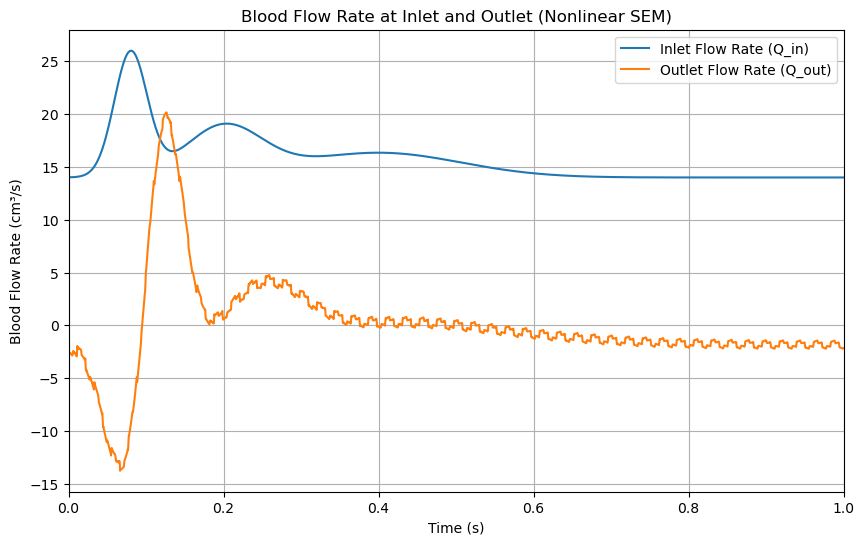

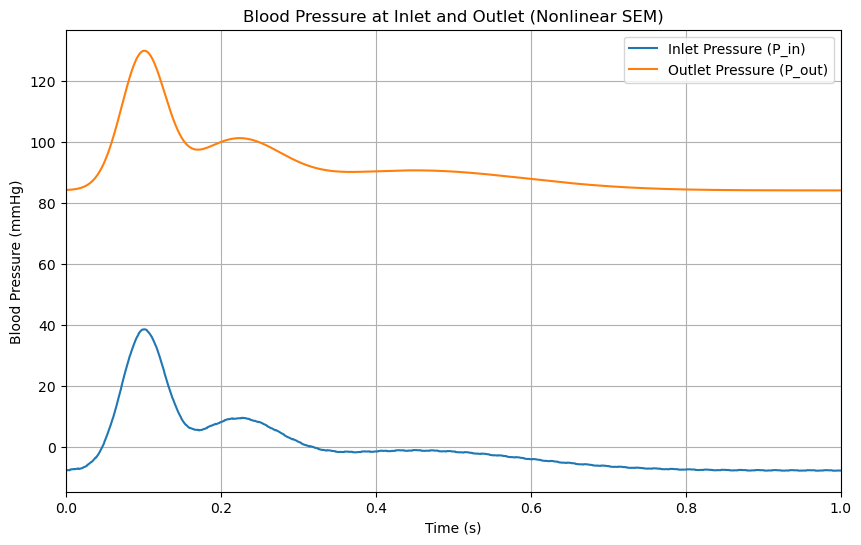

In [2]:
# --- Run nonlinear SEM solver ---
t, q_in_t, p_in_t, q_out_t, p_out_t = nonlinear_sem_aft(params, T=1.0, N=2048, max_iter=20, tol=1e-7)

# Convert units for plotting
q_in_cm3s = q_in_t * 1e6      # m^3/s to cm^3/s
q_out_cm3s = q_out_t * 1e6
p_in_mmHg = p_in_t / 133.322  # Pa to mmHg
p_out_mmHg = p_out_t / 133.322

# --- Plot results to show nonlinear effects ---

plt.figure(figsize=(10, 6))
plt.plot(t, q_in_cm3s, label='Inlet Flow Rate (Q_in)')
plt.plot(t, q_out_cm3s, label='Outlet Flow Rate (Q_out)')
plt.xlabel('Time (s)')
plt.ylabel('Blood Flow Rate (cm³/s)')
plt.title('Blood Flow Rate at Inlet and Outlet (Nonlinear SEM)')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, p_in_mmHg, label='Inlet Pressure (P_in)')
plt.plot(t, p_out_mmHg, label='Outlet Pressure (P_out)')
plt.xlabel('Time (s)')
plt.ylabel('Blood Pressure (mmHg)')
plt.title('Blood Pressure at Inlet and Outlet (Nonlinear SEM)')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

## Below are the key differences and modifications made for the nonlinear SEM solver compared to the linear SEM:

---

### 1. Inclusion of Nonlinear Forcing Terms

**Linear SEM:**

- The governing equations are linearized.
- The nonlinear forcing term $ \mathbf{f}_{NL} $ is assumed zero.
- The spectral element dynamic stiffness matrix $ S(\omega) $ depends only on linear system parameters.
- The solution is obtained by directly solving the frequency-domain system for each frequency component without iteration.

**Nonlinear SEM:**

- The nonlinear terms $ \mathbf{f}_{NL}(p, q) $ are explicitly included as a forcing term on the right-hand side of the spectral element equation.
- These nonlinear terms depend on the unknown pressure and flow rate fields $ p(t) $ and $ q(t) $, making the system nonlinear.
- The nonlinear forcing term is computed in the time domain because it involves nonlinear functions of $ p(t) $ and $ q(t) $ (e.g., quadratic terms like $ q^2 $).
- The nonlinear forcing term is then transformed back to the frequency domain using FFT to be used as a pseudo-force in the spectral element equation.

---

### 2. Alternating Frequency-Time (AFT) Iteration

**Linear SEM:**

- No iteration is needed.
- The solution is obtained by solving the spectral element equation directly in the frequency domain for each frequency component.

**Nonlinear SEM:**

- An iterative procedure is required because the nonlinear forcing depends on the solution itself.
- The AFT method alternates between:
  - **Frequency domain:** Solve the spectral element equation for spectral nodal DOFs $ d_p $ (pressure) and $ d_q $ (flow rate) using the current estimate of nonlinear forcing.
  - **Time domain:** Transform the spectral solution back to time domain using inverse FFT, compute the nonlinear forcing term $ f_{NL}(t) $ based on the updated $ p(t) $ and $ q(t) $.
  - **Frequency domain:** Transform the updated nonlinear forcing term back to frequency domain using FFT.
- This process repeats until convergence (change in solution between iterations is below a tolerance).

---

### 3. Modification of Velocity Profile Parameter $ \theta $

- In the nonlinear SEM, the velocity profile parameter $ \theta $ is set to a small nonzero value (e.g., $ \theta = 1 \times 10^{-3} $) to introduce velocity profile damping effects, which are part of the nonlinear behavior.
- In the linear SEM, $ \theta = 0 $, so the corresponding matrix $ K $ has zero entries, simplifying the system.

---

### 4. Nonlinear Forcing Term Approximation

- The nonlinear forcing term $ f_{NL}(t) $ is approximated based on dominant nonlinear convective terms (e.g., proportional to $ q(t)^2 $) for demonstration.
- This term is computed explicitly in the time domain at each iteration using the current solution.
- In the linear SEM, this term is absent.

---

### 5. Solution Workflow

| Step                          | Linear SEM                          | Nonlinear SEM with AFT Iteration                  |
|-------------------------------|-----------------------------------|---------------------------------------------------|
| Initialize forcing term        | Zero (no nonlinear forcing)        | Zero initially, updated each iteration             |
| For each frequency $ \omega $ | Solve $ S(\omega) d_p = d_q $ directly | Solve $ S(\omega) d_p = d_q + \hat{f}_{NL} $ including nonlinear forcing |
| Transform to time domain       | Once, after solving all frequencies | At each iteration, to compute nonlinear forcing    |
| Compute nonlinear forcing      | Not applicable                    | Compute $ f_{NL}(t) $ from $ p(t), q(t) $      |
| Transform nonlinear forcing to frequency domain | Not applicable                    | At each iteration, to update forcing in frequency domain |
| Check convergence             | Not applicable                    | Iterate until solution converges                    |

---

### Summary

- The nonlinear SEM solver extends the linear SEM by incorporating nonlinear terms that depend on the solution itself.
- The AFT iteration enables handling these nonlinearities by alternating between time and frequency domains, updating the nonlinear forcing term iteratively.
- This approach allows the spectral element method to solve nonlinear blood flow problems in viscoelastic vessels efficiently and accurately, capturing nonlinear wave propagation effects that the linear SEM cannot.

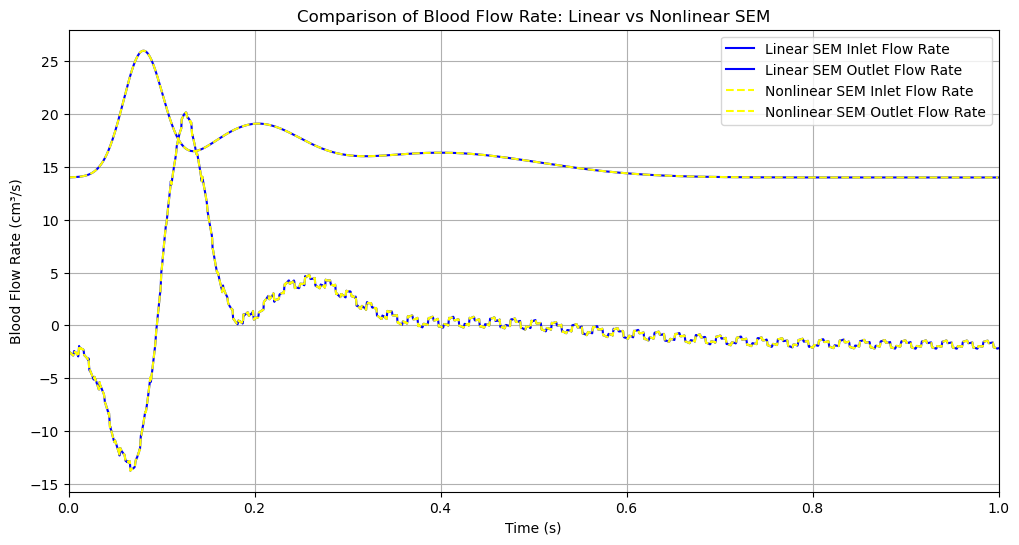

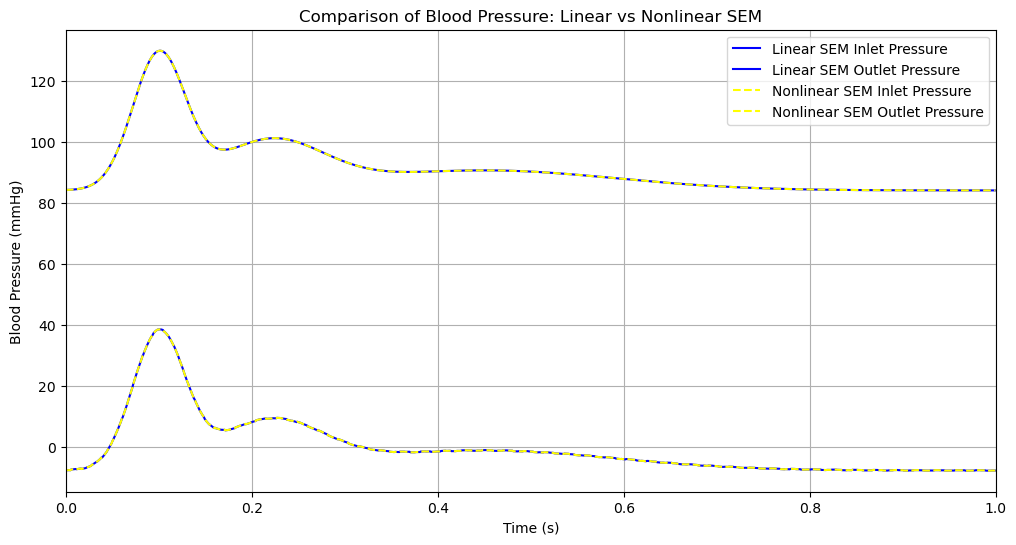

In [3]:
# --- Additional code to compare plots for Linear vs Nonlinear SEM ---

# First, define a linear SEM solver function (no nonlinear forcing, theta=0)
def linear_sem_solver(params, T=1.0, N=2048):
    """
    Linear SEM solver without nonlinear forcing.
    Inputs:
        params: dictionary of physical and model parameters (theta=0)
        T: total time period (s)
        N: number of time samples (power of 2 for FFT)
    Returns:
        t: time vector
        q_in_t: inlet flow rate time history (given BC)
        p_in_t: inlet pressure time history (computed)
        q_out_t: outlet flow rate time history (computed)
        p_out_t: outlet pressure time history (given BC)
    """
    L = params['L']
    dt = T / N
    t = np.linspace(0, T, N, endpoint=False)

    # Define inlet flow rate q_in(t) and outlet pressure p_out(t) as physiological waveforms
    def inlet_flow(t):
        Qd = params['Qd']
        Qp = 26e-6  # peak flow rate (m^3/s)
        tau = t % 1.0
        f1 = np.exp(-((tau - 0.08) / 0.03) ** 2)
        f2 = 0.4 * np.exp(-((tau - 0.20) / 0.07) ** 2)
        f3 = 0.2 * np.exp(-((tau - 0.40) / 0.15) ** 2)
        shape = f1 + f2 + f3
        shape /= np.max(shape)
        return Qd + (Qp - Qd) * shape

    def outlet_pressure(t):
        Pd = 84.2 * 133.322  # convert mmHg to Pa
        Ps = 130.0 * 133.322
        tau = t % 1.0
        p1 = np.exp(-((tau - 0.10) / 0.04) ** 2)
        p2 = 0.35 * np.exp(-((tau - 0.22) / 0.08) ** 2)
        p3 = 0.15 * np.exp(-((tau - 0.45) / 0.20) ** 2)
        shape = p1 + p2 + p3
        shape /= np.max(shape)
        return Pd + (Ps - Pd) * shape

    q_in_t = inlet_flow(t)
    p_out_t = outlet_pressure(t)

    freq = np.fft.fftfreq(N, dt)
    omega = 2.0 * np.pi * freq

    p_in_fft = np.zeros(N, dtype=complex)
    q_out_fft = np.zeros(N, dtype=complex)

    q_in_fft = np.fft.fft(q_in_t)
    p_out_fft = np.fft.fft(p_out_t)

    for n, w in enumerate(omega):
        if abs(w) < 1e-12:
            p_in_fft[n] = 0.0
            q_out_fft[n] = 0.0
            continue

        S = sem_dynam_stiffness(w, params)

        S11, S12 = S[0, 0], S[0, 1]
        S21, S22 = S[1, 0], S[1, 1]

        qin = q_in_fft[n]
        pout = p_out_fft[n]

        p_in_fft[n] = (qin - S12 * pout) / S11
        q_out_fft[n] = -S21 * p_in_fft[n] - S22 * pout

    p_in_t = np.fft.ifft(p_in_fft).real
    q_out_t = np.fft.ifft(q_out_fft).real

    return t, q_in_t, p_in_t, q_out_t, p_out_t

# --- Run linear SEM solver with theta=0 ---
params_linear = params.copy()
params_linear['theta'] = 0.0
params_linear['alpha'] = 0.0  # update alpha accordingly

t_lin, q_in_lin, p_in_lin, q_out_lin, p_out_lin = linear_sem_solver(params_linear, T=1.0, N=2048)

# --- Run nonlinear SEM solver with theta nonzero (already run previously) ---
# t, q_in_t, p_in_t, q_out_t, p_out_t = nonlinear_sem_aft(params, T=1.0, N=2048, max_iter=20, tol=1e-7)

# Convert units for plotting
q_in_lin_cm3s = q_in_lin * 1e6
q_out_lin_cm3s = q_out_lin * 1e6
p_in_lin_mmHg = p_in_lin / 133.322
p_out_lin_mmHg = p_out_lin / 133.322

q_in_nonlin_cm3s = q_in_t * 1e6
q_out_nonlin_cm3s = q_out_t * 1e6
p_in_nonlin_mmHg = p_in_t / 133.322
p_out_nonlin_mmHg = p_out_t / 133.322

# --- Plot comparison of blood flow rates ---
plt.figure(figsize=(12, 6))
plt.plot(t_lin, q_in_lin_cm3s, color='blue', linestyle='-', label='Linear SEM Inlet Flow Rate')
plt.plot(t_lin, q_out_lin_cm3s, color='blue', linestyle='-', label='Linear SEM Outlet Flow Rate')
plt.plot(t, q_in_nonlin_cm3s, color='yellow', linestyle='--', label='Nonlinear SEM Inlet Flow Rate')
plt.plot(t, q_out_nonlin_cm3s, color='yellow', linestyle='--', label='Nonlinear SEM Outlet Flow Rate')

plt.xlabel('Time (s)')
plt.ylabel('Blood Flow Rate (cm³/s)')
plt.title('Comparison of Blood Flow Rate: Linear vs Nonlinear SEM')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

# --- Plot comparison of blood pressures ---
plt.figure(figsize=(12, 6))
plt.plot(t_lin, p_in_lin_mmHg, 'b-', label='Linear SEM Inlet Pressure')
plt.plot(t_lin, p_out_lin_mmHg, 'b-', label='Linear SEM Outlet Pressure')
plt.plot(t, p_in_nonlin_mmHg, color='yellow', linestyle='--',  label='Nonlinear SEM Inlet Pressure')
plt.plot(t, p_out_nonlin_mmHg, color='yellow', linestyle='--',  label='Nonlinear SEM Outlet Pressure')
plt.xlabel('Time (s)')
plt.ylabel('Blood Pressure (mmHg)')
plt.title('Comparison of Blood Pressure: Linear vs Nonlinear SEM')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

### Explanation:
- The linear SEM solver is implemented as a function linear_sem_solver that solves the spectral element equations without nonlinear forcing (i.e., with theta=0 and alpha=0).
- The nonlinear SEM solver is assumed to have been run already (from previous code) and returns time-domain signals.
- Both solutions are converted to consistent units (cm³/s for flow rate, mmHg for pressure).
- Two plots are generated:
    - Blood flow rate comparison at inlet and outlet for linear (blue) and nonlinear (yellow) SEM.
    - Blood pressure comparison at inlet and outlet for linear (blue) and nonlinear (yellow) SEM.
    - Solid lines represent linear inlet & oulet values, dashed lines represent non-linear inlet & oulet outlet values.
    - This visual comparison highlights the effect of linear and nonlinear terms on the blood flow and pressure waveforms.

### Code generating plots for the linear and non-linear spectral elements methods
- case1: blood flow rate at inlet (linear vs nonlinear SEM) 
- case2: blood pressure at outlet (linear vs nonlinear SEM)

### Explanation:
- Case 1 plot compares the blood flow rate at the inlet between the linear and nonlinear SEM solution 
- Case 2 plot compares the blood pressure at the outlet between the linear and nonlinear SEM solution
- Blue solid lines represent the linear SEM result
- Red dashed lines represent the nonlinear SEM results
- Both plots include legends, axis labels, titles, and grid for clarity.
- The x-axis is limited to one cardiac cycle (0 to 1 second) for focused comparison.

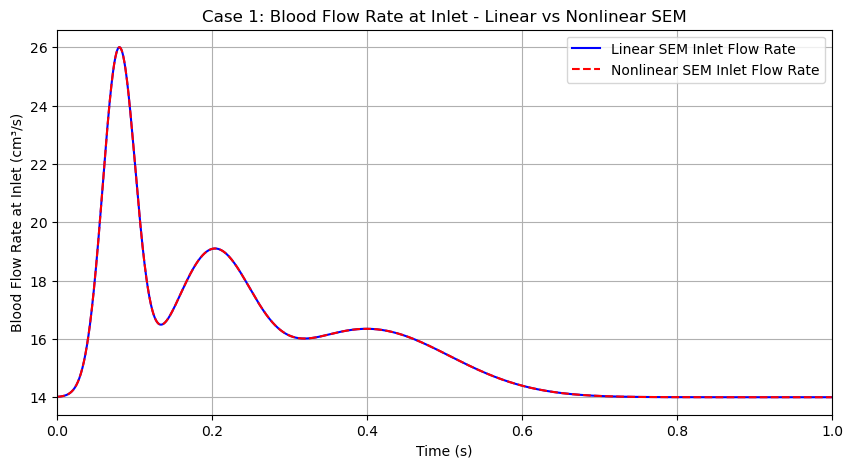

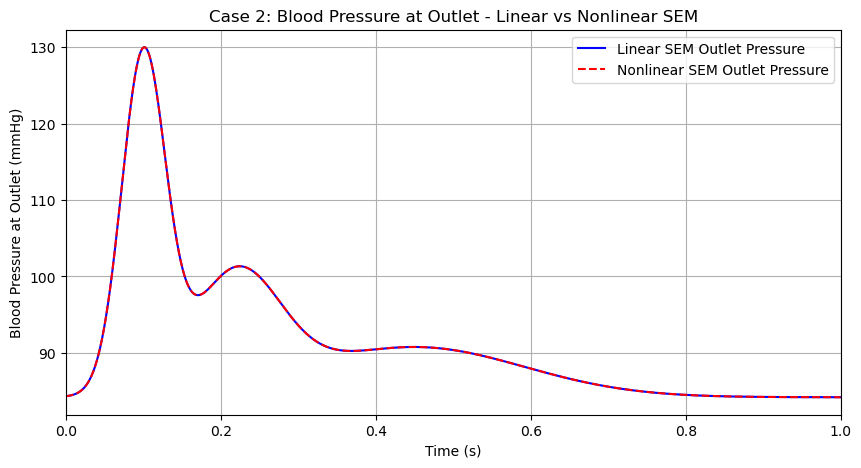

In [4]:
# --- Additional code to generate comparison plots for Case 1 and Case 2 ---

# Case 1: Blood flow rate at inlet (linear vs nonlinear SEM)
plt.figure(figsize=(10, 5))
plt.plot(t_lin, q_in_lin_cm3s, 'b-', label='Linear SEM Inlet Flow Rate')
plt.plot(t, q_in_nonlin_cm3s, 'r--', label='Nonlinear SEM Inlet Flow Rate')
plt.xlabel('Time (s)')
plt.ylabel('Blood Flow Rate at Inlet (cm³/s)')
plt.title('Case 1: Blood Flow Rate at Inlet - Linear vs Nonlinear SEM')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

# Case 2: Blood pressure at outlet (linear vs nonlinear SEM)
plt.figure(figsize=(10, 5))
plt.plot(t_lin, p_out_lin_mmHg, 'b-', label='Linear SEM Outlet Pressure')
plt.plot(t, p_out_nonlin_mmHg, 'r--', label='Nonlinear SEM Outlet Pressure')
plt.xlabel('Time (s)')
plt.ylabel('Blood Pressure at Outlet (mmHg)')
plt.title('Case 2: Blood Pressure at Outlet - Linear vs Nonlinear SEM')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

### Nonlinear SEM testing case using S = I to validate the frequency domain implementation.

In [5]:
def nonlinear_sem_fft_ifft():
    import numpy as np

    T = 1.0
    N = 2048
    t = np.linspace(0.0, T, N, endpoint=False)
    dt = t[1] - t[0]

    def inlet_flow(t, params):
        Qd = 1.4e-05# params["Qd"]
        Qp =  2.6e-05 # 26e-6 #params["Qp"]
        tau = (t % 1.0)

        f1 = np.exp(-((tau - 0.08) / 0.03) ** 2) * 1.0
        f2 = np.exp(-((tau - 0.20) / 0.07) ** 2) * 0.4
        f3 = np.exp(-((tau - 0.40) / 0.15) ** 2) * 0.2

        shape = f1 + f2 + f3
        shape = shape / np.max(shape)

        return Qd + (Qp - Qd) * shape

    def outlet_pressure(t, params):
        Pd = 11225.7124 # 84.2 * 133.322 # params["Pd"] * 133.322
        Ps = 17331.86 #130.0 * 133.322 # params["Ps"] * 133.322
        tau = (t % 1.0)

        p1 = np.exp(-((tau - 0.10) / 0.04) ** 2) * 1.0
        p2 = 0.35 * np.exp(-((tau - 0.22) / 0.08) ** 2)
        p3 = 0.15 * np.exp(-((tau - 0.45) / 0.20) ** 2)

        shape = p1 + p2 + p3
        shape = shape / np.max(shape)

        return Pd + (Ps - Pd) * shape

    qint = inlet_flow(t, params)
    poutt = outlet_pressure(t, params)

    qin_fft = np.fft.fft(qint)
    pout_fft = np.fft.fft(poutt)

    freq = np.fft.fftfreq(N, dt)
    omega = 2 * np.pi * freq

    pin_fft = np.zeros(N, dtype=complex)
    qout_fft = np.zeros(N, dtype=complex)

    # For nonlinear SEM test, we use nonlinear spectral element dynamic stiffness matrix
    for n, w in enumerate(omega):
        if abs(w) < 1e-12:
            pin_fft[n] = qin_fft[n]
            qout_fft[n] = -pout_fft[n]
            continue

        # identity dynamic stiffness matrix for testing
        S = numpy.eye(2, dtype=complex)

        S11 = S[0, 0]
        S12 = S[0, 1]
        S21 = S[1, 0]
        S22 = S[1, 1]

        qin = qin_fft[n]
        pout = pout_fft[n]

        # solve for pin and qout in spectral space
        pin = (qin - S12 * pout) / S11
        pin_fft[n] = pin

        qout = -S21 * pin - S22 * pout
        qout_fft[n] = qout

    

    pintifft = np.fft.ifft(pin_fft).real
    qoutifft = np.fft.ifft(qout_fft).real

    return t, qint, pintifft, qoutifft, poutt



# run the test SEM evaluation
# --- Run nonlinear SEM solver ---
t, qint, pintifft, qoutifft, poutt = nonlinear_sem_fft_ifft()

# absolute errors
err_in = numpy.max(numpy.abs(pintifft - qint))
err_out = numpy.max(numpy.abs(qoutifft + poutt))

# relative errors
rel_in = err_in / numpy.max(numpy.abs(qint))
rel_out = err_out / numpy.max(numpy.abs(poutt))

# tolerances
atol = 1e-10
rtol = 1e-8

# assertion tests
assert (err_in < atol) or (rel_in < rtol), (
    f"Inlet error too large: abs={err_in}, rel={rel_in}"
)

assert (err_out < atol) or (rel_out < rtol), (
    f"Outlet error too large: abs={err_out}, rel={rel_out}"
)

print("Nonlinear inlet abs/rel error:", err_in, rel_in)
print("Nonlinear outlet abs/rel error:", err_out, rel_out)




def sem_fft_ifft():

    # time grid
    T = 1.0
    N = 2048
    t = numpy.linspace(0.0, T, N, endpoint=False)
    dt = t[1] - t[0]
    

    # Inlet flow signal based on three Gaussian components.
    # These represent the primary systolic peak, a secondary shoulder,
    # and a broader diastolic contribution. The waveform is normalized
    # and scaled between Qd (diastolic flow) and Qp (peak flow).
    def inlet_flow(t, params):
        Qd = params["Qd"] #1.4e-05
        Qp = 2.6e-05 #params["Qp"]
        tau = (t % 1.0)

        f1 = numpy.exp(-((tau - 0.08) / 0.03) ** 2) * 1.0
        f2 = numpy.exp(-((tau - 0.20) / 0.07) ** 2) * 0.4
        f3 = numpy.exp(-((tau - 0.40) / 0.15) ** 2) * 0.2

        shape = f1 + f2 + f3
        shape = shape / numpy.max(shape)

        return Qd + (Qp - Qd) * shape

    # Outlet pressure signal using the same three component structure.
    # Pd and Ps are converted from mmHg to Pascals.
    def outlet_pressure(t, params):
        Pd = 11225.7124 #params["Pd"] * 133.322
        Ps = 17331.86 # params["Ps"] * 133.322
        tau = (t % 1.0)

        p1 = numpy.exp(-((tau - 0.10) / 0.04) ** 2) * 1.0
        p2 = 0.35 * numpy.exp(-((tau - 0.22) / 0.08) ** 2)
        p3 = 0.15 * numpy.exp(-((tau - 0.45) / 0.20) ** 2)

        shape = p1 + p2 + p3
        shape = shape / numpy.max(shape)

        return Pd + (Ps - Pd) * shape

    # time domain boundary conditions
    qint = inlet_flow(t, params)
    poutt = outlet_pressure(t, params)

    # apply FFT to inlet flow and outlet pressure
    qin_fft = numpy.fft.fft(qint)
    pout_fft = numpy.fft.fft(poutt)

    freq = numpy.fft.fftfreq(N, dt)
    omega = 2 * numpy.pi * freq

    # allocate arrays for spectral unknowns
    pin_fft = numpy.zeros(N, dtype=complex)
    qout_fft = numpy.zeros(N, dtype=complex)

    # frequency domain solve
    for n, w in enumerate(omega):

        # direct handling of the zero frequency mode
        if abs(w) < 1e-12:
            pin_fft[n] = qin_fft[n]
            qout_fft[n] = -pout_fft[n]
            continue

        # identity dynamic stiffness matrix for testing
        S = numpy.eye(2, dtype=complex)

        S11 = S[0, 0]
        S12 = S[0, 1]
        S21 = S[1, 0]
        S22 = S[1, 1]

        qin = qin_fft[n]
        pout = pout_fft[n]

        # solve for pin and qout in spectral space
        pin = (qin - S12 * pout) / S11
        pin_fft[n] = pin

        qout = -S21 * pin - S22 * pout
        qout_fft[n] = qout

        # reference calculation for direct mapping check
        # dp = numpy.array([pin_fft[n], pout_fft[n]], complex)
        # dq = S @ dp
        # qin_fft[n] = dq[0]
        # qout_fft[n] = -dq[1]

    # inverse FFT to recover time domain fields
    pintifft = numpy.fft.ifft(pin_fft).real
    qoutifft = numpy.fft.ifft(qout_fft).real

    return t, qint, pintifft, qoutifft, poutt

# run the test SEM evaluation
t, qint, pintifft, qoutifft, poutt = sem_fft_ifft()

# absolute errors
err_in = numpy.max(numpy.abs(pintifft - qint))
err_out = numpy.max(numpy.abs(qoutifft + poutt))

# relative errors
rel_in = err_in / numpy.max(numpy.abs(qint))
rel_out = err_out / numpy.max(numpy.abs(poutt))

# tolerances
atol = 1e-10
rtol = 1e-8

# assertion tests
assert (err_in < atol) or (rel_in < rtol), (
    f"Inlet error too large: abs={err_in}, rel={rel_in}"
)

assert (err_out < atol) or (rel_out < rtol), (
    f"Outlet error too large: abs={err_out}, rel={rel_out}"
)

print("linear inlet abs/rel error:", err_in, rel_in)
print("linear outlet abs/rel error:", err_out, rel_out)


Nonlinear inlet abs/rel error: 1.6940658945086007e-20 6.51563805580231e-16
Nonlinear outlet abs/rel error: 9.094947017729282e-12 5.247530858043674e-16
linear inlet abs/rel error: 1.6940658945086007e-20 6.51563805580231e-16
linear outlet abs/rel error: 9.094947017729282e-12 5.247530858043674e-16


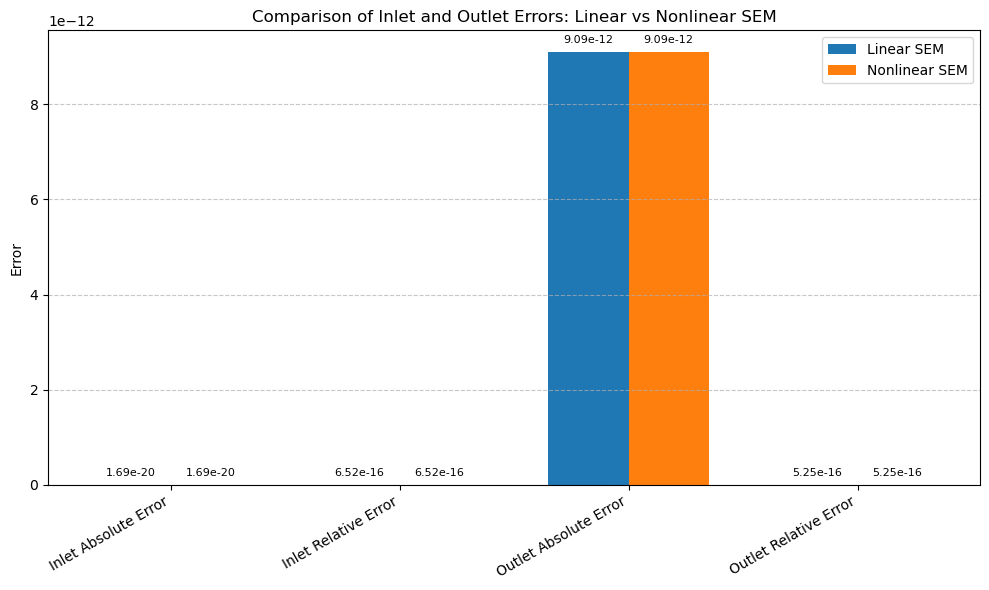

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Run linear SEM test
t_lin, qint_lin, pintifft_lin, qoutifft_lin, poutt_lin = sem_fft_ifft()

# Compute errors for linear SEM test
err_in_lin = np.max(np.abs(pintifft_lin - qint_lin))
err_out_lin = np.max(np.abs(qoutifft_lin + poutt_lin))
rel_in_lin = err_in_lin / np.max(np.abs(qint_lin))
rel_out_lin = err_out_lin / np.max(np.abs(poutt_lin))

# Run nonlinear SEM test
t_nonlin, qint_nonlin, pintifft_nonlin, qoutifft_nonlin, poutt_nonlin = nonlinear_sem_fft_ifft()

# Compute errors for nonlinear SEM test
err_in_nonlin = np.max(np.abs(pintifft_nonlin - qint_nonlin))
err_out_nonlin = np.max(np.abs(qoutifft_nonlin + poutt_nonlin))
rel_in_nonlin = err_in_nonlin / np.max(np.abs(qint_nonlin))
rel_out_nonlin = err_out_nonlin / np.max(np.abs(poutt_nonlin))

# Prepare data for plotting
labels = ['Inlet Absolute Error', 'Inlet Relative Error', 'Outlet Absolute Error', 'Outlet Relative Error']
linear_errors = [err_in_lin, rel_in_lin, err_out_lin, rel_out_lin]
nonlinear_errors = [err_in_nonlin, rel_in_nonlin, err_out_nonlin, rel_out_nonlin]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, linear_errors, width, label='Linear SEM')
rects2 = ax.bar(x + width/2, nonlinear_errors, width, label='Nonlinear SEM')

# Add labels, title, and legend
ax.set_ylabel('Error')
ax.set_title('Comparison of Inlet and Outlet Errors: Linear vs Nonlinear SEM')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Annotate bars with error values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2e}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # offset text above bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()